# UK House Price Predictor - Myles Patrick Hayhurst

## Project Introduction

In this project, I set out to build a model to predict house prices using a unique UK housing dataset.

I began with a linear regression model, but quickly realised it wasn't a good fit for the data. I then transitioned to a Random Forest model, which performed much better. To address the skewed distribution of house prices in the dataset, I applied a log transformation to the target variable, which helped normalise the data.

As the project progressed, I refined the model by pruning low importance features. Finally, I compared the model's performance before and after pruning using a range of evaluation metrics.


In [2]:
# importing modules and packages
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

from kaggle.api.kaggle_api_extended import KaggleApi

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

## Data Loading and Preprocessing

In [3]:
#Checking location of file save with API in main.py file, unzipping and loading file into enviroment
print(os.listdir("./HP_data"))
zip_path = "./HP_data/uk-house-price-prediction-dataset-2015-to-2024.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./HP_data')
df = pd.read_csv("./HP_data/UK_House_Price_Prediction_dataset_2015_to_2024.csv")


['UK_House_Price_Prediction_dataset_2015_to_2024.csv', 'uk-house-price-prediction-dataset-2015-to-2024.zip']


Exploring Database

In [4]:
df.head()


,price,date,postcode,property_type,new_build,freehold,street,locality,town,district,county
0,735000,2017-08-07,LE17 5AP,D,N,F,CLAYBROOKE COURT,CLAYBROOKE PARVA,LUTTERWORTH,HARBOROUGH,LEICESTERSHIRE
1,160000,2023-02-03,SA11 4BD,T,N,F,GORED COTTAGES,MELINCOURT,NEATH,NEATH PORT TALBOT,NEATH PORT TALBOT
2,176500,2015-01-06,ME3 0DQ,S,N,F,GREEN LANE,ISLE OF GRAIN,ROCHESTER,MEDWAY,MEDWAY
3,625000,2021-10-13,RH20 3EU,D,N,F,LINFIELD COPSE,THAKEHAM,PULBOROUGH,HORSHAM,WEST SUSSEX
4,202000,2019-09-27,SN13 8EN,S,N,F,CLYDESDALE ROAD,BOX,CORSHAM,WILTSHIRE,WILTSHIRE


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   price          90000 non-null  int64 
 1   date           90000 non-null  object
 2   postcode       90000 non-null  object
 3   property_type  90000 non-null  object
 4   new_build      90000 non-null  object
 5   freehold       90000 non-null  object
 6   street         90000 non-null  object
 7   locality       90000 non-null  object
 8   town           90000 non-null  object
 9   district       90000 non-null  object
 10  county         90000 non-null  object
dtypes: int64(1), object(10)
memory usage: 7.6+ MB


## Data Cleaning and Feature Engineering

In [6]:
# Adding year collum
df["Year"] = df["date"].str[:4]

In [7]:
# Adding a average house price collum for each propert type in an county
avg_price = df.groupby(["county", "property_type"])["price"].mean().reset_index()
avg_price.rename(columns={"price": "avg_price_county_type"}, inplace=True)
df = df.merge(avg_price, on=["county", "property_type"], how="left")

In [8]:
# One-hot encode 'property_type'
df = pd.get_dummies(df, columns=["property_type"], prefix="type", drop_first=True)
df[df.select_dtypes("bool").columns] = df.select_dtypes("bool").astype(int)

# One-hot encoding newbuild status
df["new_build"] = df["new_build"].map({"Y": 1, "N": 0})
df["freehold"] = df["freehold"].map({"F": 1, "L": 0})

In [9]:
# Removing collums that wont be used in modeling 
df = df.drop(
    ["date", "town", "street", "postcode", "locality", "county", "district"], axis=1
)
print(df.head())


    price  new_build  freehold  Year  avg_price_county_type  type_F  type_O  \
0  735000          0         1  2017          371690.130073       0       0   
1  160000          0         1  2023           95762.278351       0       0   
2  176500          0         1  2015          309175.111111       0       0   
3  625000          0         1  2021          605987.869004       0       0   
4  202000          0         1  2019          299392.990338       0       0   

   type_S  type_T  
0       0       0  
1       0       1  
2       1       0  
3       0       0  
4       1       0  


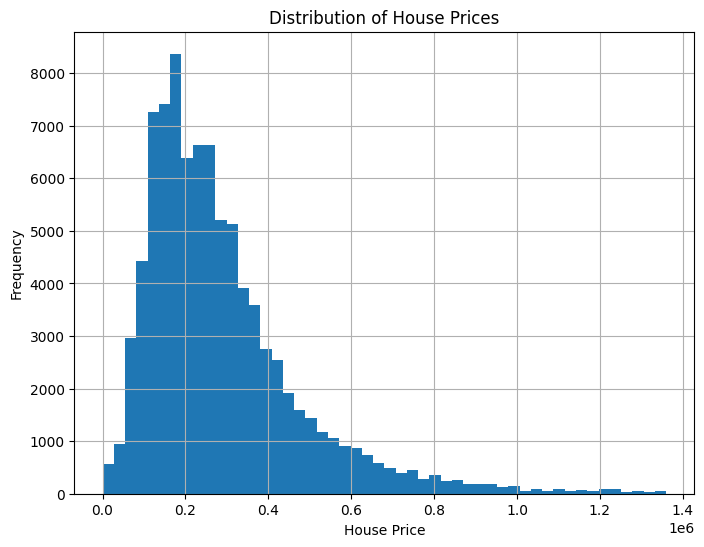

In [24]:
# Histogram looking for skewness and extreme values
plt.figure(figsize=(8, 6))
plt.hist(df["price"], bins=50)
plt.xlabel("House Price")
plt.ylabel("Frequency")
plt.title("Distribution of House Prices")
plt.grid(True)
plt.show()

In [11]:
#Function to perform Linear regression 
def run_linear_regression(X_train, X_test, y_train, y_test):
   # creating a regression model
    model = LinearRegression()

    # fitting the model
    model.fit(X_train, y_train)

    # make predictions
    log_predictions = model.predict(X_test)

    # Convert predictions back to pounds values
    predictions = np.expm1(log_predictions)
    actuals = np.expm1(y_test)

    # Scatter graph of results
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Actual vs Predicted Prices")
    plt.grid(True)
    
    # model evaluation
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = mse**0.5
    r2 = r2_score(actuals, predictions)

    # Printing metric
    print("Linear Regression Model")
    print("Mean Squared Error (in £):", mse)
    print("Mean Absolute Error (in £):", mae)
    print("Root Mean Squared Error (in £):", rmse)
    print("R² Score:", r2)
    return model 

In [12]:
#Funtion for Random Forest
def run_random_forest(X_train, X_test, y_train, y_test):
    # Creating forst model
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=3,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1,
    )

    # fitting the model
    model.fit(X_train, y_train)

    # make predictions
    log_predictions = model.predict(X_test)

    # Convert predictions back to pounds values
    predictions = np.expm1(log_predictions)
    actuals = np.expm1(y_test)
    

    # Plot: Actual vs Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], "r--")
    plt.xlabel("Actual Price (£)")
    plt.ylabel("Predicted Price (£)")
    plt.title("Random Forest: Actual vs Predicted House Prices")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Get feature importances and match with feature names
    importances = model.feature_importances_
    features = X_train.columns
    feat_importance = pd.Series(importances, index=features).sort_values(
        ascending=False
    )

    # Top 10 features as a named Series
    top_features = feat_importance.head(10)

    # Plot
    plt.figure(figsize=(8, 6))
    top_features.plot(kind="barh", color="steelblue")
    plt.title("Top 10 Feature Importances")
    plt.xlabel("Importance Score")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # model evaluation
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = mse**0.5
    r2 = r2_score(actuals,predictions)

    # Printing metric
    print("Forest Regressor Model")
    print("Mean Squared Error (in £):", mse)
    print("Mean Absolute Error (in £):", mae)
    print("Root Mean Squared Error (in £):", rmse)
    print("R² Score:", r2)
    return model, feat_importance

In [13]:
# Log-transforming the price to make model handle skew better that we can see from histogram
df["log price"] = np.log1p(df["price"])

In [14]:
# Remove top 1% most expensive properties
upper_limit = df["log price"].quantile(0.99)
df = df[df["log price"] <= upper_limit]

In [15]:
# Defining my variables
X = df.drop("log price", axis=1)
Y = df["log price"]

In [16]:
# creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=101
)

Linear Regression Model
Mean Squared Error (in £): 57818490256.3536
Mean Absolute Error (in £): 64541.152975319754
Root Mean Squared Error (in £): 240454.75719218698
R² Score: -0.625926693240767


LinearRegression()

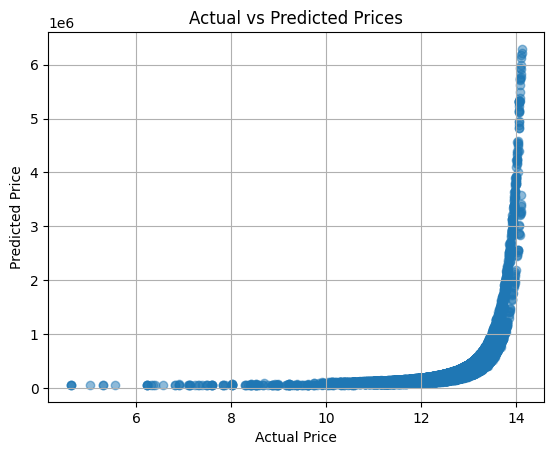

In [17]:
#Run Linear Regression Model
run_linear_regression(X_train, X_test, y_train, y_test)

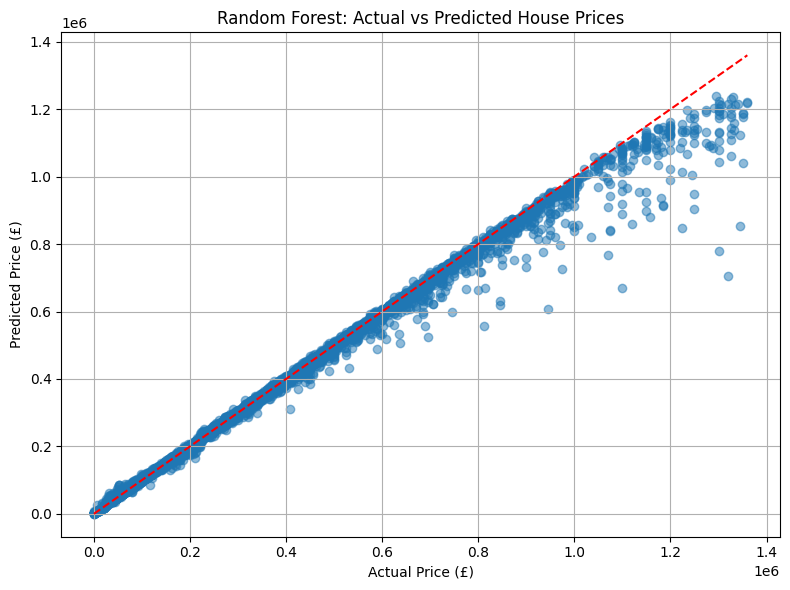

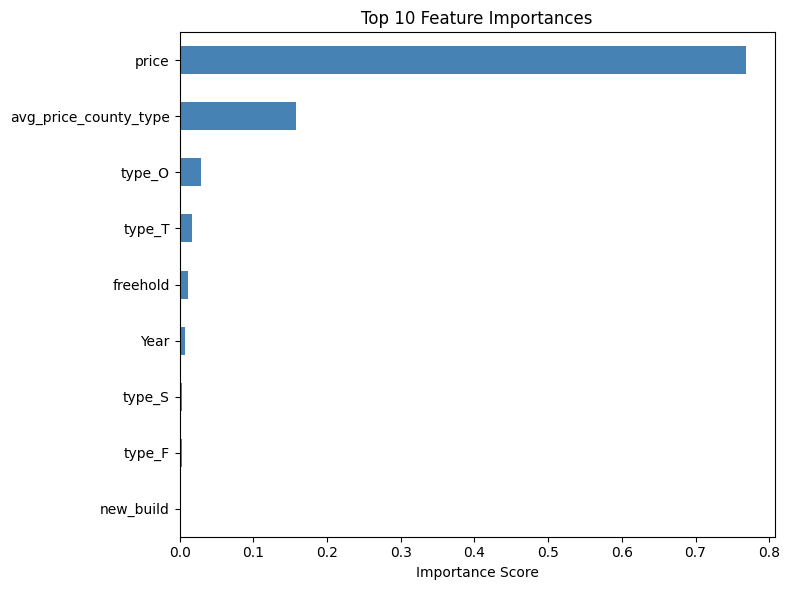

Forest Regressor Model
Mean Squared Error (in £): 220864138.094702
Mean Absolute Error (in £): 3121.7362474095803
Root Mean Squared Error (in £): 14861.498514439989
R² Score: 0.9937890301854029


In [18]:

# Run Forest model
model, feat_importance = run_random_forest(X_train, X_test, y_train, y_test)


In [19]:
# Removing low importance features and retraining to compare
low_importance_features = feat_importance[feat_importance < 0.01].index.tolist()
print("Candidates for removal:", low_importance_features)

Candidates for removal: ['Year', 'type_S', 'type_F', 'new_build']


In [20]:
# Drop low-importance features
X_reduced = X.drop(columns=low_importance_features)

In [21]:
# Train/test split with Low-importance features removed
X_train_red, X_test_red, y_train, y_test = train_test_split(
    X_reduced, Y, test_size=0.3, random_state=101
)

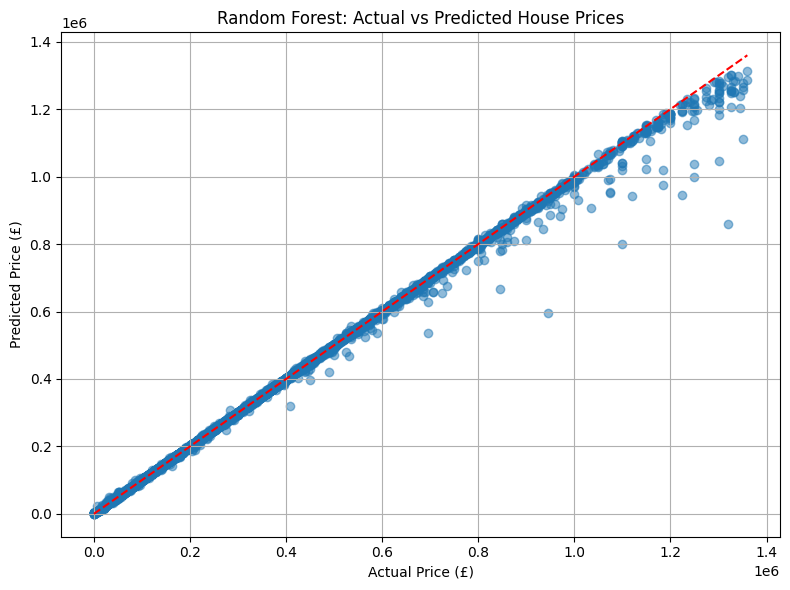

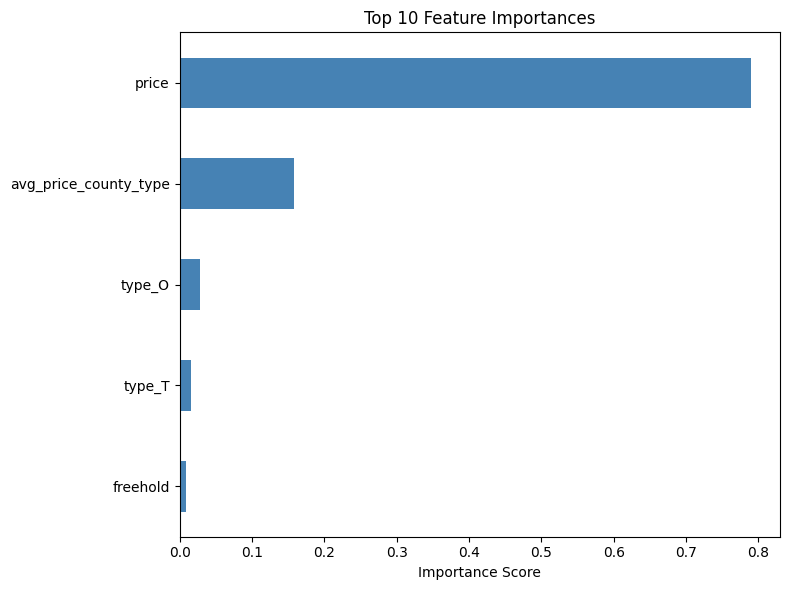

Forest Regressor Model
Mean Squared Error (in £): 54206051.2858686
Mean Absolute Error (in £): 1129.3244125064869
Root Mean Squared Error (in £): 7362.47589373769
R² Score: 0.9984756595108225


(RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=5, n_estimators=300, n_jobs=-1,
                       random_state=42),
 price                    0.790377
 avg_price_county_type    0.158234
 type_O                   0.027658
 type_T                   0.015333
 freehold                 0.008399
 dtype: float64)

In [22]:
# Run model
run_random_forest(X_train_red, X_test_red, y_train, y_test)

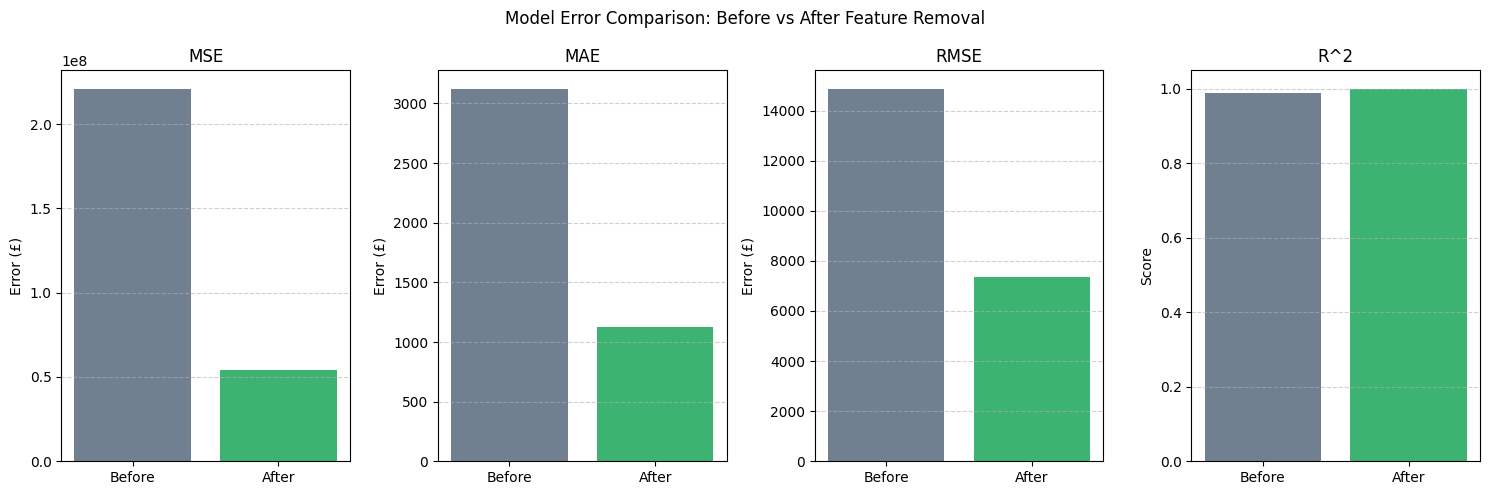

In [23]:
#Plotting Bar charts to compate error in £ before and after removing low importance variables from the model

# Metrics
labels = ["MSE", "MAE", "RMSE", "R^2"]
Forest_Before = [220864138.09, 3121.74, 14861.50, 0.99]
Forest_After = [54206051.29, 1129.32, 7362.48, 1.00]
#Linear_Regression = [57818490256.35, 64541.15, 240454.76, -0.63]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i, ax in enumerate(axs):
    ax.bar(["Before", "After"], [Forest_Before[i], Forest_After[i]], color=["slategray", "mediumseagreen"])  # <- change colors here
    ax.set_title(labels[i])
    
    # Label y-axis conditionally
    if labels[i] == "R^2":
        ax.set_ylabel("Score")
    else:
        ax.set_ylabel("Error (£)")
        
    ax.grid(True, axis="y", linestyle="--", alpha=0.6)


fig.suptitle("Model Error Comparison: Before vs After Feature Removal")
plt.tight_layout()
plt.show()